In [1]:
import gzip
import json
import pandas as pd
from nltk.corpus import stopwords
import re
from gensim.utils import tokenize

from wordcloud import WordCloud
import matplotlib.pyplot as plt

import seaborn as sns
import matplotlib.pyplot as plt
import contractions
import spacy

In [2]:
# This list will hold all JSON objects
data = []

# Open the .gz file for reading as binary
with gzip.open('software.json.gz', 'rb') as f:
    # Read file line by line
    for line in f:
        # Decode the binary data to a string
        json_str = line.decode('utf-8').strip()
        if json_str:
            # Parse the JSON string to a Python object and append to the list
            data.append(json.loads(json_str))

# Convert the list to a Pandas DataFrame
data = pd.DataFrame(data)

In [3]:
data.head()

,overall,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,vote,image
0,4.0,True,"03 11, 2014",A240ORQ2LF9LUI,0077613252,{'Format:': ' Loose Leaf'},Michelle W,The materials arrived early and were in excell...,Material Great,1394496000,NaN,NaN
1,4.0,True,"02 23, 2014",A1YCCU0YRLS0FE,0077613252,{'Format:': ' Loose Leaf'},Rosalind White Ames,I am really enjoying this book with the worksh...,Health,1393113600,NaN,NaN
2,1.0,True,"02 17, 2014",A1BJHRQDYVAY2J,0077613252,{'Format:': ' Loose Leaf'},Allan R. Baker,"IF YOU ARE TAKING THIS CLASS DON""T WASTE YOUR ...",ARE YOU KIDING ME?,1392595200,7,NaN
3,3.0,True,"02 17, 2014",APRDVZ6QBIQXT,0077613252,{'Format:': ' Loose Leaf'},Lucy,This book was missing pages!!! Important pages...,missing pages!!,1392595200,3,NaN
4,5.0,False,"10 14, 2013",A2JZTTBSLS1QXV,0077775473,NaN,Albert V.,I have used LearnSmart and can officially say ...,Best study product out there!,1381708800,NaN,NaN


In [4]:
# (459436, 12)
data.shape

(459436, 12)

In [5]:
# Subset the DataFrame to only include the 'reviewerName', 'reviewText' and 'summary' columns   - 3 columns !!! reviewerName will be possibly removed later
reviews = data[['reviewerName', 'reviewText', 'summary']]

# chcek for null values
reviews.isna().sum()

reviewerName    24
reviewText      66
summary         56
dtype: int64

In [6]:
# Drop rows with null values
reviews = reviews.dropna()

In [7]:
# Our subset have 459296 rows and 3 columns
reviews.shape

(459296, 3)

In [8]:
print(reviews['reviewText'][0])
print("")
print(reviews['summary'][0])

The materials arrived early and were in excellent condition.  However for the money spent they really should've come with a binder and not just loose leaf.

Material Great


In [9]:
nlp = spacy.load("en_core_web_md")

def preprocess_text(text):
    # Contractions
    expanded_words = []

    for word in text.split():
        # using contractions.fix to expand the shortened words
        expanded_words.append(contractions.fix(word))
    
    expanded_text = ' '.join(expanded_words)
    text = expanded_text
    # Lowercase the text
    text = text.lower()
    
    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)
    
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    text = ' '.join([word for word in text.split() if word not in stop_words])
    
    # Remove digits
    text = re.sub(r'\d+', '', text)

    # Lemmatize the words to bring them to their root form using spaCy
    words = text.split()
    lemmatized_words = [token.lemma_ for token in nlp(' '.join(words))]
    text = ' '.join(lemmatized_words)
    
    return text

In [13]:
subset = reviews.head(5).copy()  # Make a copy to avoid the SettingWithCopyWarning
subset['preprocessed_reviewText'] = subset['reviewText'].apply(preprocess_text)
subset['preprocessed_reviewText']

0    material arrive early excellent condition howe...
1    really enjoy book worksheet make review goal m...
2    take class do nt waste money call book book is...
3    book miss page important page could answer tes...
4    use learnsmart officially say amazing study to...
Name: preprocessed_reviewText, dtype: object

In [15]:
# Apply the function to the DataFrame - 70 min
reviews['preprocessed_reviewText'] = reviews['reviewText'].apply(preprocess_text)
reviews['preprocessed_reviewText']

0         material arrive early excellent condition howe...
1         really enjoy book worksheet make review goal m...
2         take class do nt waste money call book book is...
3         book miss page important page could answer tes...
4         use learnsmart officially say amazing study to...
                                ...                        
459431             instructionsno help unless want pay help
459432                                                 joke
459433    multiple license antivirus use year find quite...
459434                                           good value
459435                                 nice design easy use
Name: preprocessed_reviewText, Length: 459296, dtype: object

In [19]:
# Apply the function tokenize from gensim to the DataFrame - 1,5 min
reviews['tokens'] = reviews['preprocessed_reviewText'].apply(lambda x: list(tokenize(x)))

In [21]:
# there are a little bit more words in preprocessed_reviewText than in tokens in same row
number = 159188
print(reviews['preprocessed_reviewText'][number])
# clculate number of words in preprocessed_reviewText
print("lenght of preprocessed_reviewText: ", len(reviews['preprocessed_reviewText'][number].split()))
print(reviews['tokens'][number])
print("lenght of tokens: ", len(reviews['tokens'][number]))

need player bluray computer research player available line decide one alot top glad decide nero platinum highly recommend everone easy load update remember update useing product work much well great product
lenght of preprocessed_reviewText:  31
['need', 'player', 'bluray', 'computer', 'research', 'player', 'available', 'line', 'decide', 'one', 'alot', 'top', 'glad', 'decide', 'nero', 'platinum', 'highly', 'recommend', 'everone', 'easy', 'load', 'update', 'remember', 'update', 'useing', 'product', 'work', 'much', 'well', 'great', 'product']
lenght of tokens:  31


In [22]:
# wordcloud
# Create a list of all words in the DataFrame
all_words = [word for tokens in reviews['tokens'] for word in tokens]

# Join all words in the list
sentence = ' '.join(all_words)

# Create a WordCloud object
wordcloud = WordCloud(width=1600, height=800, max_font_size=200).generate(sentence)


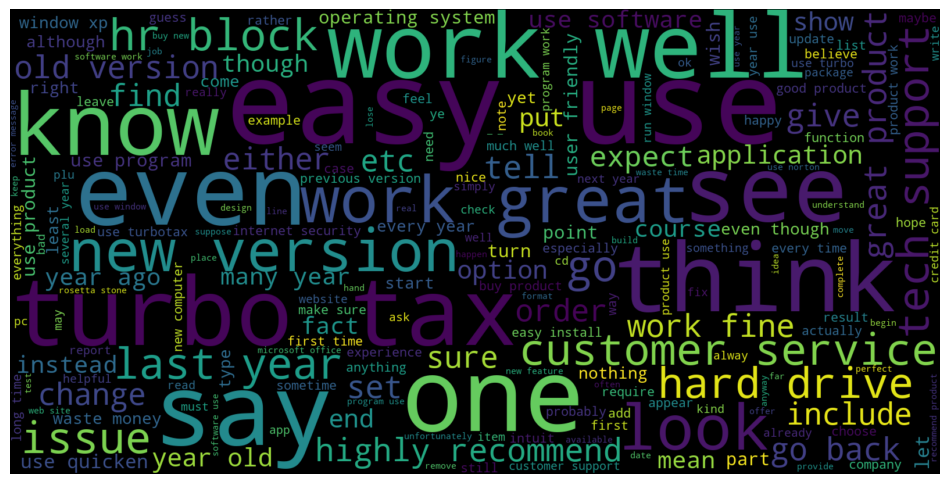

In [23]:
# Plot the WordCloud object
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()


min:  0
max:  3057
mean:  38.34170992127081


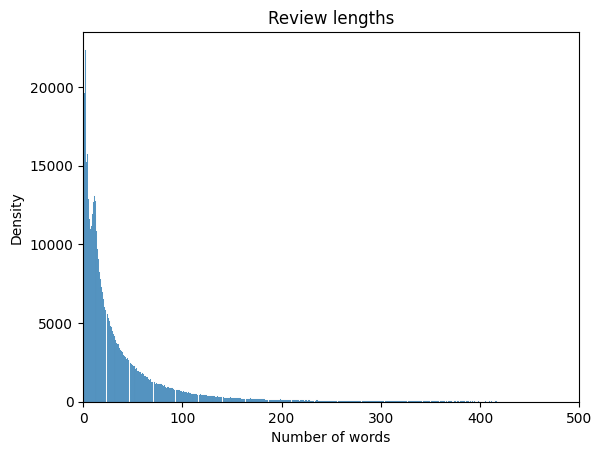

In [24]:
# word count distribution
# Create a list of review lengths
review_lengths = [len(tokens) for tokens in reviews['tokens']]
print("min: ", min(review_lengths))
print("max: ", max(review_lengths))
print("mean: ", sum(review_lengths)/len(review_lengths))

# Plot the distribution of review lengths
sns.histplot(review_lengths)
plt.title('Review lengths')
plt.xlabel('Number of words')
plt.ylabel('Density')

plt.xlim(0, 500)  # Adjust the numbers as needed

plt.show()




In [25]:
# Find the 0-length reviews
review_lengths = [len(tokens) for tokens in reviews['tokens']]
zero_length_reviews = review_lengths.count(0)
print("Number of reviews with 0 length:", zero_length_reviews)

Number of reviews with 0 length: 538


In [18]:
# Calculate the lengths of the tokens for each review
reviews['review_lengths'] = reviews['tokens'].apply(len)
reviews[reviews['review_lengths'] == 0]

,reviewerName,reviewText,summary,preprocessed_reviewText,tokens,review_lengths
677,L. Wersen,A+++,Five Stars,,[],0
5663,Jerry Allen,a,Three Stars,,[],0
6961,D D,A+,Four Stars,,[],0
8019,Dan Kratzer,A+++++++++++,Five Stars,,[],0
37845,JB518,A++++,Five Stars,,[],0
...,...,...,...,...,...,...
458096,bujabr,No,Five Stars,,[],0
459033,Patrick Fredrickson,a,Three Stars,,[],0
459350,SFC- Oxyer,a,Five Stars,,[],0
459381,Frank G.,No,No,,[],0


In [19]:
# Remove rows with a review length of 0
reviews = reviews[reviews['review_lengths'] != 0]

# Drop the 'review_lengths' column if it's no longer needed
# reviews.drop(columns=['review_lengths'], inplace=True)

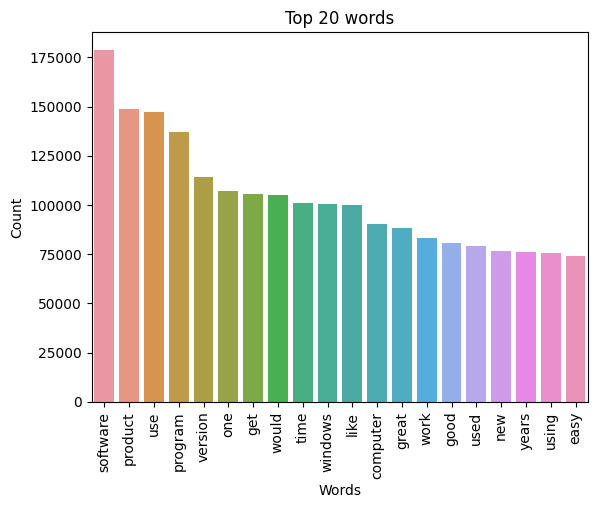

In [20]:
# top 20 words
# Create an empty dictionary
word_counts = {}

# Loop through each token list
for tokens in reviews['tokens']:
    # Loop through each token in the token list
    for token in tokens:
        # Check if the token is in the dictionary
        if token not in word_counts.keys():
            # Add the token to the dictionary with a count of 1
            word_counts[token] = 1
        else:
            # Increment the existing count by 1
            word_counts[token] += 1

# Create a DataFrame from the dictionary
counts = pd.DataFrame.from_dict(word_counts, orient='index', columns=['count'])

# Sort the DataFrame by the count values
counts.sort_values('count', ascending=False, inplace=True)

# Plot the top 20 words
sns.barplot(x=counts.head(20).index, y=counts.head(20)['count'])
plt.xticks(rotation=90)
plt.title('Top 20 words')
plt.xlabel('Words')
plt.ylabel('Count')
plt.show()

In [21]:
(counts["count"]).tail(10)

unwaveringly            1
wwwdotrootswebdotcom    1
presentatin             1
customerr               1
simthmicro              1
upade                   1
viol                    1
pracical                1
beliieve                1
overthought             1
Name: count, dtype: int64

In [22]:

# create new table with count of words only once, more than 1000 times and more than 10000 times
counts_new = pd.DataFrame(columns=['count'])
counts_new.loc['total'] = counts.shape[0]
counts_new.loc['only once'] = counts[counts['count'] == 1].shape[0]
counts_new.loc['more than 1 but less than 10 times'] = counts[(counts['count'] > 1) & (counts['count'] < 10)].shape[0]
counts_new.loc['more than 100 times'] = counts[counts['count'] > 100].shape[0]
counts_new.loc['more than 1000 times'] = counts[counts['count'] > 1000].shape[0]
counts_new.loc['more than 10000 times'] = counts[counts['count'] > 10000].shape[0]
counts_new.loc['more than 100000 times'] = counts[counts['count'] > 100000].shape[0]

# crete new column with percentage of words
counts_new['percentage'] = round(counts_new['count']/counts_new.loc['total', 'count']*100, 2)

counts_new


,count,percentage
total,117008,100.00
only once,55345,47.30
more than 1 but less than 10 times,37105,31.71
more than 100 times,8295,7.09
more than 1000 times,2335,2.00
more than 10000 times,347,0.30
more than 100000 times,10,0.01


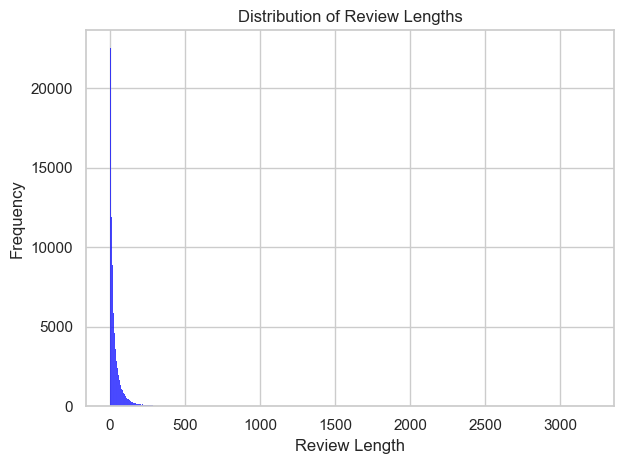

In [23]:
# Calculate the length of each sentence (number of words)

# Create a Seaborn histogram
sns.set(style="whitegrid")  # Set the style
# plt.figure(figsize=(30, 5))  # Set the figure size

# Create the histogram using document_lengths as input
sns.histplot(reviews['review_lengths'], color='blue')

# Customize the plot
plt.title("Distribution of Review Lengths")
plt.xlabel("Review Length")
plt.ylabel("Frequency")

plt.tight_layout()

# Show the plot
plt.show()

In [24]:
count_reviews_greater_than_200 = (reviews['review_lengths'] > 200).sum()
print("Number of review lengths more than 200:", count_reviews_greater_than_200)

Number of review lengths more than 200: 10537


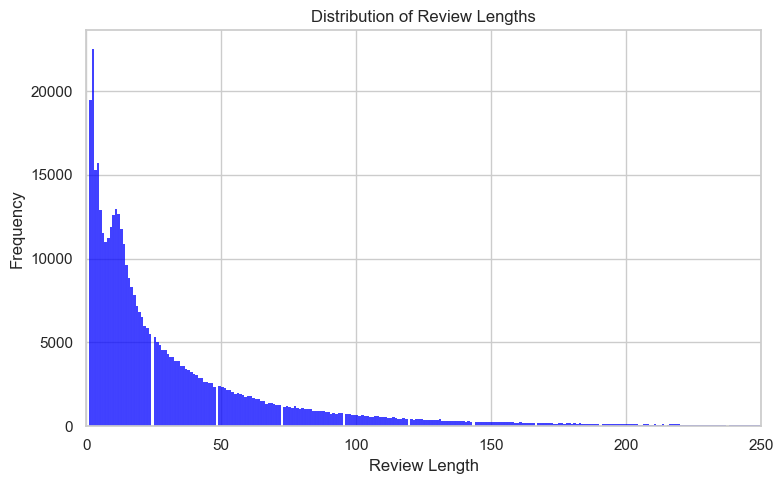

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a Seaborn histogram
sns.set(style="whitegrid")  # Set the style
plt.figure(figsize=(8, 5))  # Set the figure size

# Create the histogram using the 'review_lengths' column from your DataFrame
sns.histplot(reviews['review_lengths'], color='blue')

# Customize the plot
plt.title("Distribution of Review Lengths")
plt.xlabel("Review Length")
plt.ylabel("Frequency")

# Set the x-axis limits to show values only between 0 and 500
plt.xlim(0, 250)
plt.tight_layout()

# Show the plot
plt.show()


In [28]:
# Save the preprocessed dataframe in a pickle object
reviews.to_pickle('preprocessed_reviews.pkl')